# **프로젝트: 트랜스포머로 만드는 대화형 챗봇**

#### **프로젝트 개요**  

**1. 프로젝트 목적:**  

트랜스포머(Transformer) 아키텍처를 직접 구현하고 한국어 대화 데이터를 학습시켜, 사용자의 감정에 공감하고 적절한 위로를 건네는 챗봇을 제작한다.  


**2. 데이터셋: 🤖 [한국어 챗봇 데이터](https://github.com/songys/Chatbot_data/tree/master?tab=readme-ov-file) (송영숙님 제공)**  

- 일상, 이별, 사랑 등 3가지 테마로 구성된 약 11,823개의 한국어 Q&A 쌍
- SentencePiece를 사용하여 한국어 특성에 맞는 서브워드(Subword) 토큰화 적용


**3. 모델:**  

멀티 헤드 어텐션(Multi-Head Attention) 기반의 트랜스포머를 경량화하여 설계했다.  

- 파라미터 수 약 3,436만 개, 3개의 인코더-디코더 레이어, 512차원의 임베딩 공간

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import sentencepiece as spm

import pandas as pd
import numpy as np

import math
import os
import re
import urllib.request
import zipfile
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cu118
CUDA available: True


In [2]:
# 경로 설정
HOME_DIR = os.path.join(os.getenv("HOME"), 'work/transformer_chatbot/')
DATA_DIR = HOME_DIR + 'data/ChatbotData.csv'

## 2. 데이터 전처리

### 챗봇 데이터 기본 정보 확인

In [3]:
train_data = pd.read_csv(DATA_DIR)
pd.set_option('display.max_colwidth', 500) # 열 디스플레이 옵션 설정
print(train_data.shape)

(11823, 3)


In [4]:
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
train_data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [6]:
# 결측치 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [7]:
# 중복 확인
print(train_data.duplicated().sum())

0


### 전처리 함수 정의

In [8]:
def preprocess_sentence(sentence):
    """
    한국어 텍스트 전처리 함수
    - 특수문자 정규화
    - 중복 공백 제거
    - 불필요한 기호 정리
    """
    if not isinstance(sentence, str):
        return ""
    
    # 연속된 구두점 정규화
    sentence = re.sub(r'([!?.]){2,}', r'\1', sentence)
    
    # 한글, 영어, 숫자, 주요 문장부호를 제외한 모든 문자 제거
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    
    # 중복 공백 제거
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 앞뒤 공백 제거
    sentence = sentence.strip()
    
    return sentence

In [9]:
def prepare_chatbot_data(df):
    """
    Pandas 데이터프레임(df)에서 질문(Q)과 답변(A) 쌍을 추출하여 전처리
    """
    questions = []
    answers = []
    
    # 데이터프레임의 행을 하나씩 순회하며 Q와 A 컬럼 값을 가져오기 
    for i in range(len(df)):
        # preprocess_sentence 함수를 적용하여 정제
        question = preprocess_sentence(df['Q'].iloc[i])
        answer = preprocess_sentence(df['A'].iloc[i])
        
        # 정제 후 빈 문장이 아닌 경우에만 리스트에 추가
        if len(question) > 0 and len(answer) > 0:
            questions.append(question)
            answers.append(answer)
    
    return questions, answers

### 데이터 전처리 실행

In [10]:
questions, answers = prepare_chatbot_data(train_data)

print(f"전처리 완료: {len(questions)}개의 질문-답변 쌍")
print(f"\n예시 (처음 3개):")

# 리스트의 첫 3개 출력
for i in range(min(3, len(questions))):
    print(f"Q: {questions[i]}")
    print(f"A: {answers[i]}")
    print()

전처리 완료: 11823개의 질문-답변 쌍

예시 (처음 3개):
Q: 12시 땡!
A: 하루가 또 가네요.

Q: 1지망 학교 떨어졌어
A: 위로해 드립니다.

Q: 3박4일 놀러가고 싶다
A: 여행은 언제나 좋죠.



## 3. SentencePiece 토크나이저 학습

In [11]:
# 코퍼스 파일 준비
corpus_path = 'chatbot_corpus.txt'

# 리스트 개수가 일치하는지 확인 (디버깅용)
if len(questions) == len(answers):
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for question, answer in zip(questions, answers):
            f.write(question + '\n')
            f.write(answer + '\n')
    print(f"총 {len(questions) * 2}개의 문장이 {corpus_path}에 저장되었습니다.")
else:
    print("경고: 질문과 답변의 개수가 일치하지 않습니다.")

# 파일 생성 확인
if os.path.exists(corpus_path):
    print("토크나이저 학습을 위한 코퍼스 파일이 생성되었습니다.")

총 23646개의 문장이 chatbot_corpus.txt에 저장되었습니다.
토크나이저 학습을 위한 코퍼스 파일이 생성되었습니다.


In [12]:
# SentencePiece 모델 학습
vocab_size = 8000
model_prefix = 'korean_chatbot_sp'

spm.SentencePieceTrainer.train(
    input=corpus_path,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    model_type='bpe',          # 혹은 더 유연한 'unigram' 추천
    character_coverage=1.0,    # 한국어 전체를 커버하려면 1.0 추천
    pad_id=0,                  # <pad> 토큰
    bos_id=1,                  # <s> 토큰 (Start of Sequence)
    eos_id=2,                  # </s> 토큰 (End of Sequence)
    unk_id=3                   # <unk> 토큰
    # 별도의 user_defined_symbols를 넣지 않아도 위 ID 설정으로 기본 토큰이 생성
)

# SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

print(f"SentencePiece 모델 학습 완료")
print(f"어휘 크기: {sp.get_piece_size()}") # vocab_size()보다 get_piece_size()가 더 정확

# 토큰화 테스트
test_sentence = questions[0]
print(f"\n원문: {test_sentence}")
print(f"토큰(Pieces): {sp.encode_as_pieces(test_sentence)}")
print(f"정수(IDs): {sp.encode_as_ids(test_sentence)}")

SentencePiece 모델 학습 완료
어휘 크기: 8000

원문: 12시 땡!
토큰(Pieces): ['▁12', '시', '▁땡', '!']
정수(IDs): [5552, 6812, 3199, 6930]


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: chatbot_corpus.txt
  input_format: 
  model_prefix: korean_chatbot_sp
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  

## 4. 데이터셋 클래스 생성

In [13]:
class ChatbotDataset(Dataset):
    def __init__(self, questions, answers, sp, max_len=64):
        self.questions = questions
        self.answers = answers
        self.sp = sp
        self.max_len = max_len
        
        # SentencePiece의 특수 토큰 ID 설정
        self.SOS_token = sp.bos_id() # <sos> 또는 <s>
        self.EOS_token = sp.eos_id() # <eos> 또는 </s>
        self.PAD_token = sp.pad_id() # <pad>
    
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        answer = self.answers[idx]
        
        # 인코더 입력 (Source): [SOS] + 질문 + [EOS]
        # 모델의 인코더가 질문의 시작과 끝을 알 수 있도록 함
        src = [self.SOS_token] + self.sp.encode_as_ids(question) + [self.EOS_token]
        
        # 디코더 입력 (Target Input): [SOS] + 답변
        # Teacher Forcing을 위해 정답 문장을 입력으로 사용
        trg_input = [self.SOS_token] + self.sp.encode_as_ids(answer)
        
        # 디코더 타겟 (Target Output): 답변 + [EOS]
        # 모델이 예측해야 하는 실제 목표값
        trg_output = self.sp.encode_as_ids(answer) + [self.EOS_token]
        
        # 패딩 처리 (모두 동일한 max_len으로 맞춤)
        src = self._pad_sequence(src)
        trg_input = self._pad_sequence(trg_input)
        trg_output = self._pad_sequence(trg_output)
        
        # PyTorch 모델 입력 형식에 맞게 텐서로 변환하여 반환
        return {
            'src': torch.tensor(src, dtype=torch.long),
            'trg_input': torch.tensor(trg_input, dtype=torch.long),
            'trg_output': torch.tensor(trg_output, dtype=torch.long)
        }
    
    def _pad_sequence(self, seq):
        if len(seq) < self.max_len:
            seq = seq + [self.PAD_token] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        return seq

In [14]:
# 훈련/검증 데이터 분할
split_idx = int(len(questions) * 0.9)
train_questions = questions[:split_idx]
train_answers = answers[:split_idx]
val_questions = questions[split_idx:]
val_answers = answers[split_idx:]

In [15]:
# 데이터셋 생성
max_seq_len = 64
train_dataset = ChatbotDataset(train_questions, train_answers, sp, max_seq_len)
val_dataset = ChatbotDataset(val_questions, val_answers, sp, max_seq_len)

print(f"학습 데이터: {len(train_dataset)}")
print(f"검증 데이터: {len(val_dataset)}")

학습 데이터: 10640
검증 데이터: 1183


## 5. 트랜스포머 모델 구성

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % num_heads == 0
        
        self.depth = d_model // num_heads
        
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        self.dense = nn.Linear(d_model, d_model)
    
    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)
    
    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = torch.matmul(q, k.transpose(-2, -1)) # 두 차원을 서로 교차
        
        # math.sqrt를 사용하여 CPU/GPU 동기화 병목 방지
        dk = k.size(-1)
        scaled_attention_logits = matmul_qk / math.sqrt(dk)
        
        if mask is not None:
            # In-place 연산 피하기
            scaled_attention_logits = scaled_attention_logits + (mask * -1e9)
        
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, v)
        
        return output, attention_weights
    
    def forward(self, q, k, v, mask):
        batch_size = q.size(0)
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)
        
        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.contiguous().view(batch_size, -1, self.d_model)
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [18]:
class PointWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model, dff):
        super(PointWiseFeedForwardNetwork, self).__init__()
        self.dense1 = nn.Linear(d_model, dff)
        self.dense2 = nn.Linear(dff, d_model)
    
    def forward(self, x):
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        return x

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)
        
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
    
    def forward(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask) # q, k, v 순서
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)
        
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6) # 분모가 0이 되는 것을 방지하는 안전 장치
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm3 = nn.LayerNorm(d_model, eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
    
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # mha1: Masked Self-Attention (디코더가 생성한 단어들끼리 (x) 비교)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) # 미래 시점의 단어를 가림
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x) # 잔차 연결 + 레이어 정규화

        # mha2: Encoder-Decoder Attention (디코더의 질문(out1)으로 인코더의 정보(enc_output)를 찾음)
        # 순서: q, k, v
        # q == out1
        # k, v == enc_output
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, padding_mask) # 인코더의 패딩을 무시
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1) # 잔차 연결 + 레이어 정규화
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2) # 잔차 연결 + 레이어 정규화
        
        return out3, attn_weights_block1, attn_weights_block2

In [21]:
class Encoder(nn.Module):
    """인코더 층을 여러 개 쌓아올린 인코더 모듈"""
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)
        
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, dff, dropout_rate) 
                                         for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, mask):
        # 임베딩 레이어 통과
        x = self.embedding(x) # (batch_size, input_seq_len, d_model)
        
        # 임베딩 스케일링 (상수로 계산하는 것이 효율적)
        x = x * math.sqrt(self.d_model)
        
        # 위치 인코딩 추가
        x = self.pos_encoding(x)
        
        # 드롭아웃
        x = self.dropout(x)
        
        # 인코더 레이어 반복 통과 (N층 쌓기)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
        
        return x # (batch_size, input_seq_len, d_model)

In [22]:
class Decoder(nn.Module):
    """디코더 층을 여러 개 쌓아올린 디코더 모듈"""
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)
        
        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, dff, dropout_rate) 
                                         for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
            attention_weights = {}
            
            # 타겟 임베딩 및 스케일링
            x = self.embedding(x) 
        
            # 인코더와 동일하게 math.sqrt 사용
            x = x * math.sqrt(self.d_model)
            
            # 위치 인코딩 및 드롭아웃
            x = self.pos_encoding(x)
            x = self.dropout(x)
            
            # 디코더 레이어 N층 통과
            for i in range(self.num_layers):
                # x: 출력 벡터, block1: Self-Attention 가중치, block2: Cross-Attention 가중치
                x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)
                
                # 레이어별 가중치 저장
                attention_weights[f'decoder_layer{i+1}_block1'] = block1
                attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
            # x의 shape: (batch_size, target_seq_len, d_model)
            return x, attention_weights

In [23]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, pe_input, pe_target, dropout_rate=0.1):
        super(Transformer, self).__init__()
        
        # 인코더 정의
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, dropout_rate)
        
        # 디코더 정의
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, dropout_rate)
        
        # 최종 출력 선형 레이어 (벡터 -> 단어별 점수)
        self.final_layer = nn.Linear(d_model, target_vocab_size)
    
    def forward(self, inp, tar, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # 인코더 통과
        enc_output = self.encoder(inp, enc_padding_mask) # (batch_size, inp_seq_len, d_model)
        
        # 디코더 통과 (인코더 출력값 enc_output을 전달!)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)
        
        # 최종 단어 예측
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

## 6. 마스크 생성 함수 정의

In [24]:
def create_padding_mask(seq, pad_token=0):
    """
    패딩 마스크 생성
    """
    mask = (seq == pad_token).float()
    return mask.unsqueeze(1).unsqueeze(2)

In [25]:
def create_look_ahead_mask(size, device):
    """
    Look-ahead 마스크 생성 (디코더용)
    """
    # 미래 시점의 단어를 가리기 위해 1로 채워진 상삼각 행렬을 생성
    mask = torch.triu(torch.ones((size, size), device=device), diagonal=1)
    return mask

In [26]:
def create_masks(inp, tar, pad_token=0):
    """
    모든 마스크 생성
    """
    device = inp.device
    
    # 인코더 패딩 마스크
    enc_padding_mask = create_padding_mask(inp, pad_token)
    
    # 디코더의 두 번째 어텐션 블록용 패딩 마스크 (인코더 출력 가리기)
    dec_padding_mask = create_padding_mask(inp, pad_token)
    
    # 디코더의 첫 번째 어텐션 블록용 마스크 (미래 단어 가리기 + 타겟 패딩 가리기)
    look_ahead_mask = create_look_ahead_mask(tar.size(1), device)
    dec_target_padding_mask = create_padding_mask(tar, pad_token).to(device)
    
    # 두 마스크를 합쳐서 1인 곳은 모두 가림 -> torch.maximum 사용 이유 
    combined_mask = torch.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

## 7. 모델 학습 함수 정의

In [27]:
def accuracy_function(predictions, targets, pad_id=0):
    """
    predictions: (batch_size, seq_len, vocab_size) - 모델의 출력(Logits)
    targets: (batch_size, seq_len) - 실제 정답 토큰(Label)
    """
    # 마지막 차원(vocab_size)에서 가장 높은 확률의 인덱스를 추출
    preds = predictions.argmax(dim=-1)  
    
    # 패딩 토큰을 제외한 마스크 생성
    mask = (targets != pad_id)
    
    # 정답과 일치하면서 패딩이 아닌 것만 계산
    correct = (preds == targets) & mask
    
    # 정확도 계산: (맞은 개수) / (패딩 제외 전체 개수)
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [28]:
def train_epoch(model, dataloader, criterion, optimizer, device, pad_token):
    """모델 학습 함수"""
    model.train()
    total_loss = 0
    total_acc = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for batch in progress_bar:
        # 데이터 장치 이동
        encoder_input = batch['src'].to(device)
        decoder_input = batch['trg_input'].to(device)
        decoder_target = batch['trg_output'].to(device) # 이것이 바로 targets!
        
        # 마스크 생성
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(
            encoder_input, decoder_input, pad_token
        )
        
        optimizer.zero_grad()
        
        # 순전파 (Forward)
        # predictions shape: (batch_size, seq_len, vocab_size)
        predictions, _ = model(
            encoder_input, 
            decoder_input, 
            enc_padding_mask, 
            look_ahead_mask, 
            dec_padding_mask
        )
        
        # 손실 계산 (view를 통해 차원을 펼쳐서 계산)
        # predictions shape: (batch_size, seq_len, vocab_size) -> (-1, vocab_size)
        # decoder_target shape: (batch_size, seq_len) -> (-1)
        # target_vocab_size 대신 predictions.size(-1)을 써서 유연하게 대처
        loss = criterion(predictions.view(-1, predictions.size(-1)), 
                         decoder_target.view(-1))
        
        # 정확도 계산 (우리가 이름을 바꾼 그 함수!)
        acc = accuracy_function(predictions, decoder_target, pad_id=pad_token)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 기울기 폭주 방지 (gradient clipping)
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += acc.item()
        
        # 실시간 상태 표시
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{acc.item():.4f}"
        })
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [29]:
def validate_epoch(model, dataloader, criterion, device, pad_token):
    """모델 검증 함수 (정확도 계산 포함)"""
    model.eval() # 평가 모드 전환
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad(): # 기울기 계산 비활성화
        for batch in tqdm(dataloader, desc='Validation'):
            encoder_input = batch['src'].to(device)
            decoder_input = batch['trg_input'].to(device)
            decoder_target = batch['trg_output'].to(device)

            # 마스크 생성
            enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(
                encoder_input, decoder_input, pad_token
            )

            # 순전파
            predictions, _ = model(
                encoder_input, 
                decoder_input, 
                enc_padding_mask, 
                look_ahead_mask, 
                dec_padding_mask
            )

            # 손실 계산 (predictions.size(-1) 사용 권장)
            loss = criterion(predictions.view(-1, predictions.size(-1)), 
                             decoder_target.view(-1))
            
            acc = accuracy_function(predictions, decoder_target, pad_id=pad_token)
            
            total_loss += loss.item()
            total_acc += acc.item()
            
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [30]:
def predict_answer(model, question, sp, device, max_len=64, temperature=0.8):
    """온도 조절 샘플링이 적용된 모델 예측 함수"""
    model.eval() # 평가 모드 전환

    # 토큰 정의
    SOS_token = sp.bos_id()
    EOS_token = sp.eos_id()
    PAD_token = sp.pad_id()
    
    # 인코더 입력 준비
    question = preprocess_sentence(question)
    enc_input_ids = [SOS_token] + sp.encode_as_ids(question) + [EOS_token]
    
    # 인코더 입력은 고정 길이로 패딩 처리
    if len(enc_input_ids) < max_len:
        enc_input_ids += [PAD_token] * (max_len - len(enc_input_ids))
    else:
        enc_input_ids = enc_input_ids[:max_len]
    
    encoder_input = torch.tensor([enc_input_ids], dtype=torch.long).to(device)
    
    # 디코더 입력 시작 (SOS로 시작)
    decoder_input_list = [SOS_token]
    
    with torch.no_grad():
        for i in range(max_len):
            # 현재까지의 단어들만 텐서로 변환 (패딩 없이 진행)
            decoder_input = torch.tensor([decoder_input_list], dtype=torch.long).to(device)
            
            # 마스크 생성 (현재 decoder_input 길이에 맞춰서 생성)
            enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(
                encoder_input, decoder_input, PAD_token
            )
            
            # 예측
            predictions, _ = model(
                encoder_input,
                decoder_input,
                enc_padding_mask,
                look_ahead_mask,
                dec_padding_mask
            )

            # 온도 조절 및 샘플링 적용 
            logits = predictions[0, -1, :] # 마지막 타임스텝의 예측값 추출: (vocab_size,)

            # 온도를 나누어 분포를 조절 (T가 낮으면 정답에 집중, T가 높으면 다양성 증가)
            logits = logits / temperature

            # 소프트맥스를 통해 확률 분포 생성
            probabilities = torch.softmax(logits, dim=-1)

            # argmax 대신 확률 분포에 따른 샘플링 수행
            predicted_id = torch.multinomial(probabilities, num_samples=1).item()
            
            # 종료 토큰이 나오면 멈춤
            if predicted_id == EOS_token:
                break
            
            # 예측된 단어를 다음 입력 리스트에 추가
            decoder_input_list.append(predicted_id)
            
    # SOS 토큰 제외하고 디코딩 (문장 복원)
    answer = sp.decode_ids(decoder_input_list[1:])
    return answer

## 8. 모델 학습

In [31]:
# 하이퍼파라미터 설정

# 모델 구조 관련
num_layers = 3
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.2

# 데이터 및 임베딩 파라미터
input_vocab_size = sp.vocab_size()
target_vocab_size = sp.vocab_size()
max_position_encoding = max_seq_len

# 학습 및 추론 관련
epochs = 30
batch_size = 128
learning_rate = 0.0001
inference_temp = 0.5
early_stop_patience = 5

print(f"모델 파라미터:")
print(f"  레이어 수: {num_layers}")
print(f"  모델 차원: {d_model}")
print(f"  FFN 차원: {dff}")
print(f"  어텐션 헤드: {num_heads}")
print(f"  배치 크기: {batch_size}")
print(f"  에폭: {epochs}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

모델 파라미터:
  레이어 수: 3
  모델 차원: 512
  FFN 차원: 2048
  어텐션 헤드: 8
  배치 크기: 128
  에폭: 30
사용 디바이스: cuda


In [32]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"학습 배치 수: {len(train_loader)}")
print(f"검증 배치 수: {len(val_loader)}")

학습 배치 수: 84
검증 배치 수: 10


In [33]:
# 인코딩 확인
# 단일 배치 가져오기
sample_batch = next(iter(train_loader))

# 딕셔너리 형태인 경우 키(Key) 목록 추출
if isinstance(sample_batch, dict):
    keys = list(sample_batch.keys())
    batch_size_dim = len(sample_batch[keys[0]])
    
    for i in range(min(3, batch_size_dim)):
        print(f"\n[Sample {i+1}]")
        for key in keys:
            data = sample_batch[key][i]
            
            if torch.is_tensor(data):
                indices = data.tolist()
                clean_indices = [idx for idx in indices if idx != sp.pad_id()]
                print(f"{key} (인코딩): {clean_indices}")
                try:
                    print(f"{key} (복원)  : {sp.decode_ids(clean_indices)}")
                except: pass
            else:
                print(f"{key} (데이터): {data}")

# 리스트/튜플 형태인 경우
else:
    for i in range(min(3, len(sample_batch[0]))):
        print(f"\n[Sample {i+1}]")
        for idx, item in enumerate(sample_batch):
            data = item[i]
            if torch.is_tensor(data):
                indices = data.tolist()
                clean_indices = [idx_val for idx_val in indices if idx_val != sp.pad_id()]
                print(f"요소 {idx} (인코딩): {clean_indices}")
                try:
                    print(f"요소 {idx} (복원)  : {sp.decode_ids(clean_indices)}")
                except: pass
            else:
                print(f"요소 {idx} (데이터): {data}")


[Sample 1]
src (인코딩): [1, 359, 1464, 4870, 1230, 685, 1337, 2]
src (복원)  : 남자친구가 뭔가 수상한데 말을 안해
trg_input (인코딩): [1, 2206, 1299, 234, 3984, 6771]
trg_input (복원)  : 말할 때까지 조금 기다려주세요.
trg_output (인코딩): [2206, 1299, 234, 3984, 6771, 2]
trg_output (복원)  : 말할 때까지 조금 기다려주세요.

[Sample 2]
src (인코딩): [1, 879, 89, 260, 3345, 6837, 2]
src (복원)  : 모르는 사람이 자꾸 쳐다봐
trg_input (인코딩): [1, 2247, 5674, 134, 219, 112, 6771]
trg_input (복원)  : 혹시 반한 걸 수도 있어요.
trg_output (인코딩): [2247, 5674, 134, 219, 112, 6771, 2]
trg_output (복원)  : 혹시 반한 걸 수도 있어요.

[Sample 3]
src (인코딩): [1, 1771, 2]
src (복원)  : 보고싶어
trg_input (인코딩): [1, 292, 843, 422, 6771]
trg_input (복원)  : 그럴 거라 생각해요.
trg_output (인코딩): [292, 843, 422, 6771, 2]
trg_output (복원)  : 그럴 거라 생각해요.


In [34]:
# 모델 초기화
model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    pe_input=max_position_encoding,
    pe_target=max_position_encoding,
    dropout_rate=dropout_rate
).to(device)

# 모델 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n전체 파라미터: {total_params:,}")
print(f"학습 파라미터: {trainable_params:,}")


전체 파라미터: 34,365,248
학습 파라미터: 34,365,248


In [35]:
# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=sp.pad_id(),
                               label_smoothing=0.1) # target 값에 대해 100% 확신을 갖지 않게 하여 과적합 방지
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), 
                       eps=1e-9, weight_decay=1e-5) # 가중치가 너무 커지는 것을 방지

# 학습률 스케줄러
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
# 학습이 정체될 때 factor=0.5로 학습률을 깎아줌

In [36]:
# 학습 실행
patience_counter = 0 
best_val_loss = float('inf')

# 결과 저장을 위한 리스트 초기화
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 학습 과정 모니터링을 위한 테스트용 질문
test_questions = ["안녕?", "오늘 날씨 어때?", "이름이 뭐야?", "배고프다."]

for epoch in range(epochs):
    # 학습 및 검증 진행
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, sp.pad_id())
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, sp.pad_id())
    
    # loss, acc 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # 학습률 스케줄러 업데이트 (loss 기반)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # 성능이 가장 좋은 모델 저장 및 Early Stopping 체크
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 개선되었으므로 카운터 리셋
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'd_model': d_model,
            'num_layers': num_layers,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        }, 'best_korean_chatbot_model.pt')
        status_msg = "★ Best Model Saved!"
    else:
        patience_counter += 1
        status_msg = f"patience: {patience_counter}/{early_stop_patience}"

    # 출력 제어: 1에폭, 마지막 에폭, 그리고 매 에폭(또는 5의 배수)마다 출력
    # % 포맷팅(.2%)을 사용하여 소수를 퍼센트로 변환합니다.
    if (epoch + 1) == 1 or (epoch + 1) == epochs or (epoch + 1) % 1 == 0: # 매 에폭 확인을 위해 % 1로 수정
        print(f"\n{'='*20} Epoch {epoch+1}/{epochs} {'='*20}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2%}")
        print(f"LR: {current_lr:.6f} | {status_msg}")
        
        # 모델 추론 테스트
        print("\n[Model Test]")
        for q in test_questions:
            ans = predict_answer(model, q, sp, device, max_len=max_seq_len, temperature=inference_temp)
            print(f"Q: {q} -> A: {ans}")

    # Early Stopping 발동
    if patience_counter >= early_stop_patience:
        print(f"\n{early_stop_patience}에폭 동안 개선이 없어 조기 종료합니다. (Best Val Loss: {best_val_loss:.4f})")
        break

print("\n" + "="*50)
print(f"학습 완료! 최종 Best Val Acc: {max(val_accs):.2%}")
print("="*50)

Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 1/30 ====================
Train Loss: 6.5774 | Train Acc: 29.02%
Val Loss: 6.4010   | Val Acc: 27.56%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 좋은 도움이.
Q: 오늘 날씨 어때? -> A: 너무 잘 수 있을 거예요.
Q: 이름이 뭐야? -> A: 좋은.
Q: 배고프다. -> A: 좋은 더 잘 마세요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 2/30 ====================
Train Loss: 6.0262 | Train Acc: 30.87%
Val Loss: 6.2308   | Val Acc: 28.82%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 좋은 사람.
Q: 오늘 날씨 어때? -> A: 많이 너무는 수 있을 거예요.
Q: 이름이 뭐야? -> A: 많이 좀 더 많이.
Q: 배고프다. -> A: 좋은 사람 거예요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 3/30 ====================
Train Loss: 5.7748 | Train Acc: 32.09%
Val Loss: 6.1155   | Val Acc: 29.63%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 많이 더 하세요.
Q: 오늘 날씨 어때? -> A: 제가 있잖아요.
Q: 이름이 뭐야? -> A: 같이 있는하게 감고.
Q: 배고프다. -> A: 당신이 더을보는


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 4/30 ====================
Train Loss: 5.5245 | Train Acc: 33.47%
Val Loss: 6.0189   | Val Acc: 30.62%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 제가 있잖아요.
Q: 오늘 날씨 어때? -> A: 같이로 올 거예요.
Q: 이름이 뭐야? -> A: 안 좋은 사람 마다.
Q: 배고프다. -> A: 제가 있잖아요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 5/30 ====================
Train Loss: 5.3076 | Train Acc: 35.11%
Val Loss: 5.9621   | Val Acc: 31.01%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 운명
Q: 오늘 날씨 어때? -> A: 당신이 더 좋은 거예요.
Q: 이름이 뭐야? -> A: 그 사람 마다만해주세요.
Q: 배고프다. -> A: 지금은 많이하셨어요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 6/30 ====================
Train Loss: 5.1168 | Train Acc: 36.47%
Val Loss: 5.9095   | Val Acc: 31.45%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 그런 사람 만나세요.
Q: 오늘 날씨 어때? -> A: 그 사람 만날 수 있을 거예요.
Q: 이름이 뭐야? -> A: 마음 가는 대로 하세요.
Q: 배고프다. -> A: 먼저 말보다 더 많이 지쳤나봐요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 7/30 ====================
Train Loss: 4.9392 | Train Acc: 38.11%
Val Loss: 5.8700   | Val Acc: 31.77%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 혼자 힘들어하지 마세요.
Q: 오늘 날씨 어때? -> A: 그 사람 만나세요.
Q: 이름이 뭐야? -> A: 많이 지쳤나봐요.
Q: 배고프다. -> A: 결국 더 많이 사랑했던 있을 거예요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 8/30 ====================
Train Loss: 4.7872 | Train Acc: 39.81%
Val Loss: 5.8359   | Val Acc: 32.09%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 생각을 자주게를의 썸을 쌓질 거예요.
Q: 오늘 날씨 어때? -> A: 아직 시간이 흐르일 거예요.
Q: 이름이 뭐야? -> A: 같이 여행을 떠나보세요.
Q: 배고프다. -> A: 마음이 복잡지 않을 거예요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 9/30 ====================
Train Loss: 4.6387 | Train Acc: 41.45%
Val Loss: 5.8115   | Val Acc: 32.26%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 사랑은 소유하는 바랄게요.
Q: 오늘 날씨 어때? -> A: 슈퍼 생각해보세요.
Q: 이름이 뭐야? -> A: 저는 좋아요.
Q: 배고프다. -> A: 처음이 될 거예요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 10/30 ====================
Train Loss: 4.4938 | Train Acc: 43.18%
Val Loss: 5.7894   | Val Acc: 32.41%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 직접 물어보세요.
Q: 오늘 날씨 어때? -> A: 당분간은 약속을에 대한 예의가 없네요.
Q: 이름이 뭐야? -> A: 저는 좋아요.
Q: 배고프다. -> A: 저도 듣고 싶네요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 11/30 ====================
Train Loss: 4.3471 | Train Acc: 44.92%
Val Loss: 5.7642   | Val Acc: 32.83%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 직접 물어보는 게 좋을 것 같아요.
Q: 오늘 날씨 어때? -> A: 저랑 이야기 있어요.
Q: 이름이 뭐야? -> A: 저는 위로해드리는 로봇이에요.
Q: 배고프다. -> A: 일의 연속이 안 좋은 거 같아요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 12/30 ====================
Train Loss: 4.2084 | Train Acc: 46.67%
Val Loss: 5.7374   | Val Acc: 33.03%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 저는 위로해드리는 로봇이에요.
Q: 오늘 날씨 어때? -> A: 원래 있을 거예요.
Q: 이름이 뭐야? -> A: 당신이 다시쇠입니다.
Q: 배고프다. -> A: 운전 더 많이 괴로다고 말해보세요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 13/30 ====================
Train Loss: 4.0763 | Train Acc: 48.47%
Val Loss: 5.7397   | Val Acc: 33.18%
LR: 0.000100 | patience: 1/5

[Model Test]
Q: 안녕? -> A: 서로 다르게 안 좋아요.
Q: 오늘 날씨 어때? -> A: 그 사람 마다 다르겠지요.
Q: 이름이 뭐야? -> A: 사람 마다 다르겠지요.
Q: 배고프다. -> A: 많이 만나보세요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 14/30 ====================
Train Loss: 3.9474 | Train Acc: 50.23%
Val Loss: 5.7258   | Val Acc: 33.23%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 도서관 데이트 몰라요.
Q: 오늘 날씨 어때? -> A: 저도 궁금하네요.
Q: 이름이 뭐야? -> A: 저는 좋아요.
Q: 배고프다. -> A: 너무 많이 받으세요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 15/30 ====================
Train Loss: 3.8201 | Train Acc: 52.35%
Val Loss: 5.7197   | Val Acc: 33.52%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 멋진 말이네요.
Q: 오늘 날씨 어때? -> A: 당장 비행기표은 해보세요.
Q: 이름이 뭐야? -> A: 사람마다 다르겠지만 사귀고 난 후가 좋겠어요.
Q: 배고프다. -> A: 저도 좋아해요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 16/30 ====================
Train Loss: 3.6857 | Train Acc: 54.24%
Val Loss: 5.7087   | Val Acc: 33.83%
LR: 0.000100 | ★ Best Model Saved!

[Model Test]
Q: 안녕? -> A: 아무래도 뿌듯할 수 있어요.
Q: 오늘 날씨 어때? -> A: 저도 궁금하네요.
Q: 이름이 뭐야? -> A: 저는 위로봇입니다.
Q: 배고프다. -> A: 저도 궁금하네요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 17/30 ====================
Train Loss: 3.5703 | Train Acc: 56.22%
Val Loss: 5.7109   | Val Acc: 33.86%
LR: 0.000100 | patience: 1/5

[Model Test]
Q: 안녕? -> A: 합니다.
Q: 오늘 날씨 어때? -> A: 저도 같이 가요.
Q: 이름이 뭐야? -> A: 사람마다 다르겠지만 사귀고 난 후가 좋겠어요.
Q: 배고프다. -> A: 고민이 많은가 봐요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 18/30 ====================
Train Loss: 3.4500 | Train Acc: 58.20%
Val Loss: 5.7182   | Val Acc: 34.02%
LR: 0.000100 | patience: 2/5

[Model Test]
Q: 안녕? -> A: 당신.
Q: 오늘 날씨 어때? -> A: 저도 같이 놀아요.
Q: 이름이 뭐야? -> A: 사람마다 다르겠지만 사귀고 난 후가 좋겠어요.
Q: 배고프다. -> A: 저도 보고 싶어요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 19/30 ====================
Train Loss: 3.3338 | Train Acc: 60.26%
Val Loss: 5.7165   | Val Acc: 34.11%
LR: 0.000050 | patience: 3/5

[Model Test]
Q: 안녕? -> A: 저는 좋아요.
Q: 오늘 날씨 어때? -> A: 물질이 접촉하는 것도 좋겠죠.
Q: 이름이 뭐야? -> A: 저는 위로봇입니다.
Q: 배고프다. -> A: 저도 보고 싶어요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 20/30 ====================
Train Loss: 3.1963 | Train Acc: 62.64%
Val Loss: 5.7172   | Val Acc: 34.33%
LR: 0.000050 | patience: 4/5

[Model Test]
Q: 안녕? -> A: 안녕하세요.
Q: 오늘 날씨 어때? -> A: 저도 싫어요.
Q: 이름이 뭐야? -> A: 사람마다 다르겠지만 사귀고 난 후가 좋겠어요.
Q: 배고프다. -> A: 얼른 주무세요.


Training:   0%|          | 0/84 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]


==================== Epoch 21/30 ====================
Train Loss: 3.1287 | Train Acc: 63.95%
Val Loss: 5.7250   | Val Acc: 34.28%
LR: 0.000050 | patience: 5/5

[Model Test]
Q: 안녕? -> A: 저는 위로해드리는 로봇이에요.
Q: 오늘 날씨 어때? -> A: 고민하는 게 좋겠어요.
Q: 이름이 뭐야? -> A: 저는 위로해드리는 로봇이에요.
Q: 배고프다. -> A: 얼른 주무세요.

5에폭 동안 개선이 없어 조기 종료합니다. (Best Val Loss: 5.7087)

학습 완료! 최종 Best Val Acc: 34.33%


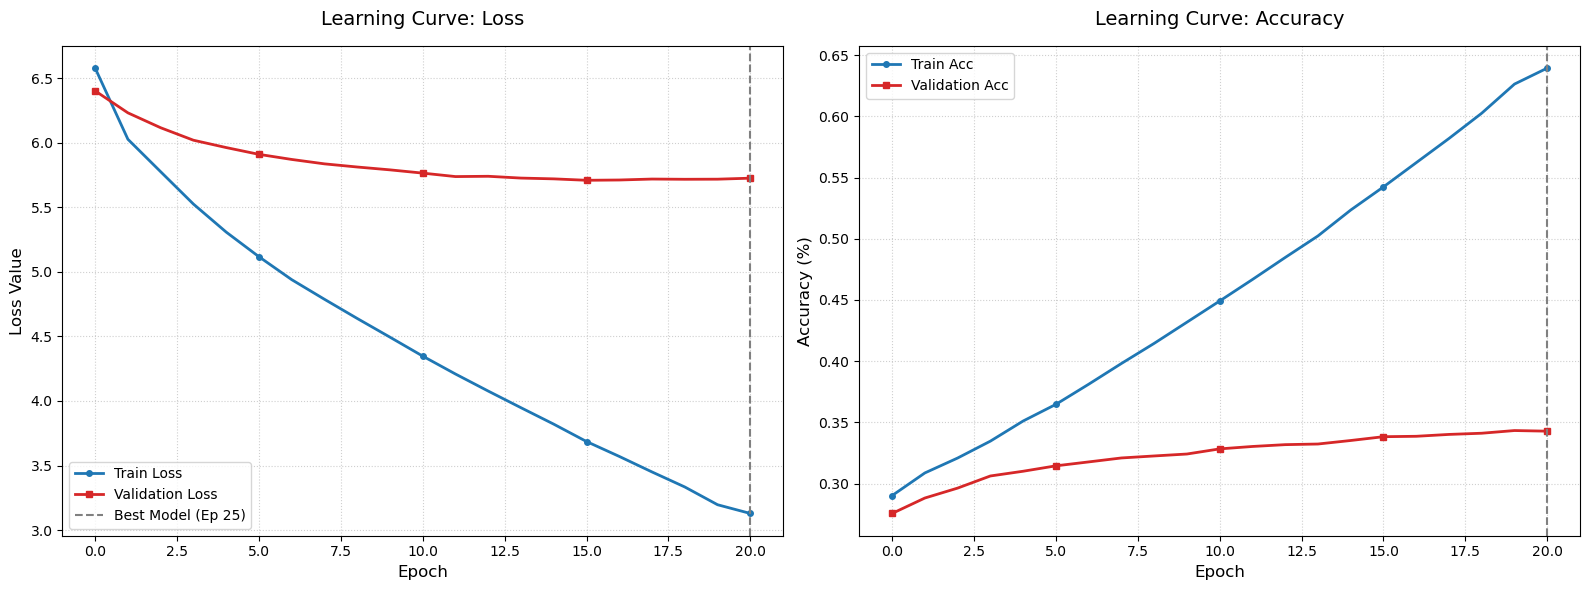

In [46]:
# 학습 곡선 시각화

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-muted') # 깔끔한 테마 설정
plt.figure(figsize=(16, 6))

# 1. Loss 그래프 (왼쪽)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#1f77b4', linewidth=2, marker='o', markersize=4, markevery=5)
plt.plot(val_losses, label='Validation Loss', color='#d62728', linewidth=2, marker='s', markersize=4, markevery=5)
plt.axvline(x=20, color='gray', linestyle='--', label='Best Model (Ep 25)') # 베스트 모델 시점 표시
plt.title('Learning Curve: Loss', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# 2. Accuracy 그래프 (오른쪽)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', color='#1f77b4', linewidth=2, marker='o', markersize=4, markevery=5)
plt.plot(val_accs, label='Validation Acc', color='#d62728', linewidth=2, marker='s', markersize=4, markevery=5)
plt.axvline(x=20, color='gray', linestyle='--')
plt.title('Learning Curve: Accuracy', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

In [47]:
plt.savefig(HOME_DIR+'chatbot_learning_result.png', dpi=300) # 그래프 저장

<Figure size 640x480 with 0 Axes>

## 9. 모델 평가

In [41]:
def start_chatting(model, sp, device, temp=0.7):
    model.eval()
    print("🤖 위로봇과 대화를 시작합니다! (종료하려면 '종료' 또는 'exit' 입력)")
    print("-" * 50)
    
    while True:
        user_input = input("나: ")
        if user_input.lower() in ['종료', 'exit', 'quit']:
            print("🤖 위로봇: 다음에 또 만나요! 늘 응원할게요.")
            break
            
        if not user_input.strip():
            continue
            
        # 예측 수행 (temperature를 전달하도록 수정)
        with torch.no_grad():
            answer = predict_answer(model, user_input, sp, device, max_len=max_seq_len, temperature=temp)
        
        print(f"🤖 위로봇: {answer}")
        print("-" * 50)

In [48]:
# 저장된 베스트 모델 파일을 불러오기
checkpoint = torch.load('best_korean_chatbot_model.pt', map_location=device) # map_location은 GPU가 없는 환경에서 에러 방지

# 모델 구조에 불러온 가중치를 덮어씌우기
model.load_state_dict(checkpoint['model_state_dict'])

# 몇 번째 에폭의 모델인지 확인 출력
print(f"✅ Best 모델 로드 완료! (Epoch: {checkpoint['epoch'] + 1})")

# 채팅 함수 실행
start_chatting(model, sp, device)

✅ Best 모델 로드 완료! (Epoch: 16)
🤖 위로봇과 대화를 시작합니다! (종료하려면 '종료' 또는 'exit' 입력)
--------------------------------------------------


나:  안녕!


🤖 위로봇: 조용에 귀를 기울 괜한 맞추!
--------------------------------------------------


나:  안녕?


🤖 위로봇: 저는 위로봇입니다.
--------------------------------------------------


나:  저녁 메뉴 추천해줘.


🤖 위로봇: 맛있는 거 드세요.
--------------------------------------------------


나:  나 오늘 공부 진짜 열심히 했다.


🤖 위로봇: 쉽지는 않은 시간 만큼 택 말고 주의하세요.
--------------------------------------------------


나:  여행 왔는데 모르는 사람이 자꾸 쳐다 봐.


🤖 위로봇: 사람이니까요.
--------------------------------------------------


나:  그럼 나 안심해도 돼?


🤖 위로봇: 무슨 일이 있었나봐요.
--------------------------------------------------


나:  너 오타를 좀 낸다.


🤖 위로봇: 만남에 무슨 문제가 있었나요.
--------------------------------------------------


나:  나 이만 갈게. 안녕!


🤖 위로봇: 저랑 놀아요.
--------------------------------------------------


나:  아니야 가야 해


🤖 위로봇: 그래서컷 기대가볼까하나봐요.
--------------------------------------------------


나:  잘 지내고 있어.


🤖 위로봇: 잘 견뎌내고 있는 시간이겠네요.
--------------------------------------------------


나:  응. 좀 견뎌.


🤖 위로봇: 예뻐요.
--------------------------------------------------


나:  갑자기 무슨 소리야?


🤖 위로봇: 서로에게 좋은 사람 만날 수 있을 거예요.
--------------------------------------------------


나:  나 간다. 종료


🤖 위로봇: 이제 내려주세요.
--------------------------------------------------


나:  종료


🤖 위로봇: 다음에 또 만나요! 늘 응원할게요.


## 정리

**1. 과적합 현상**  

- Train 지표: Loss는 수직 하강하고, Accuracy는 약 `64%`까지 꾸준히 상승했다.
  
- Validation 지표: 검증 정확도는 34% 부근에서 정체(Plateau)되었다. 10에폭 이후부터 Train과 Val의 간격이 벌어지는 전형적인 과적합(Overfitting) 징후가 관찰되었다.

데이터셋에 비해 복잡한 모델을 사용한 것이 원인이 아닐까 한다. 레이어 수와 어텐션 헤드 등 모델 구조를 단순화할 필요가 있다.  
<br><br/>
**2. 문맥 이해 능력 부족**  

- "안녕?"에 "위로봇이에요"라고 답한 것은 '인사'라는 상황에 대한 학습이 이루어진 결과이다.
- 하지만 "너 오타를 좀 많이 내는 것 같아"라는 "만남에 무슨 문제가 있었나요"라는 답변을 하는 것이나, "아니야 가야 해"라고 하자 "그래서컷 기대가볼까하나봐요"라고 하는 것을 보면 질문의 핵심 의도를 파악하지 못한 채, 데이터셋 내에 자주 등장하는 지엽적인 키워드에만 모델이 반응(Attention)하고 있는 것으로 보인다.

## 회고

- 데이터셋 자체는 결측치도 중복값도 없는 아주 깔끔하게 정제되어 있었다. 그러나 약 1만 2천여 행의 비교적 작은 크기라 그런지 챗봇에게 다양한 문맥을 학습시키기에는 많이 어려웠다.
<br><br/>
- 마지막 Exploration 프로젝트를 진행하며 트랜스포머 모델(GPT 등)에서의 온도 조절 샘플링(Temperature Sampling)을 새롭게 알게 됐다.

  * 온도는 모델이 출력한 결과(Logits)의 확률 분포를 조절하여, 다음에 올 단어를 선택할 때의 확신 수준을 결정하는 매개변수다.
  * 모델이 예측한 원시 점수(Logits)를 온도($T$)로 나눈 뒤 소프트맥스 함수를 적용하여, $T$ 값에 따라 확률 분포의 날카로움(Sharpness)을 조절하는 원리이다.
    
    - 온도가 낮아지면 (`0.1 ~ 0.5`) 확률 분포가 날카로워져 가장 점수가 높은 단어에만 집중하게 된다. 답변이 일관되고 문법적으로 안정되지만, 흔한 답변만 반복하는 현상이 나타날 수 있다.
      
    - 온도가 높아지면 (`0.8 ~ 1.5`) 확률 분포가 완만해져(Flattening) 2~3순위의 단어들도 선택될 기회를 얻는다. 답변이 다채롭고 창의적으로 변하지만, 문맥을 벗어나거나 존재하지 않는 단어를 만드는 환각(Hallucination) 현상이 잦아진다.
<br><br/>
- 참고 문헌:
  * Ashish Vaswani 외 7인, Attention is All You Need [[paper](https://arxiv.org/abs/1706.03762)]
  * NLP examples (chatbot) @ rightlit on Github ([link](https://github.com/rightlit/chatbot-examples))
  * Medium blog: How to sample from language models ([link](https://medium.com/data-science/how-to-sample-from-language-models-682bceb97277))